# 05 - Advanced Models

Modelos avançados (e.g., Gradient Boosting, XGBoost/LightGBM se disponível) e comparação.



In [81]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error, mean_squared_error

import sys
import os

# Adiciona o diretório raiz do projeto ao PYTHONPATH
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.data_ingestion import load_wine_dataframe
from src.data_processing import DataPreprocessor


import matplotlib.pyplot as plt

In [82]:
# Optional imports if available
try:
    from xgboost import XGBRegressor
    has_xgb = True
except Exception:
    has_xgb = False

HF_REPO = os.getenv("HF_DATASET_REPO", "henriquebap/wine-ml-dataset")
FILENAME = os.getenv("HF_DATASET_FILENAME", "WineQT.csv")

FEATURES = [
    "fixed acidity","volatile acidity","citric acid","residual sugar","chlorides",
    "free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"
]

df = load_wine_dataframe(repo_id=HF_REPO, filename=FILENAME)
pre = DataPreprocessor(feature_columns=FEATURES, target_column="quality")
df_p = pre.fit_transform(df)
X = df_p[FEATURES]
y = df_p["quality"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "GBR": GradientBoostingRegressor(random_state=42),
}
if has_xgb:
    models["XGB"] = XGBRegressor(n_estimators=400, max_depth=6, learning_rate=0.05, subsample=0.9, colsample_bytree=0.8, random_state=42)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    results.append({
        "model": name,
        "rmse_mean": -scores.mean(),
        "rmse_std": scores.std(),
    })

pd.DataFrame(results).sort_values("rmse_mean")


,model,rmse_mean,rmse_std
1,XGB,0.657794,0.051531
0,GBR,0.661511,0.042731


### XGBOOST

In [83]:
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 1]
}


grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'colsample_bytree': [0.8, 1], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200, ...], ...}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [84]:
print("Melhores parâmetros:", grid_search.best_params_)
print("Melhor score:", grid_search.best_score_)

Melhores parâmetros: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.8}
Melhor score: -0.3779997587203979


In [85]:
xgb = XGBRegressor(**grid_search.best_params_, random_state=42)

In [86]:
xgb.fit(x_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,1
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [87]:
y_pred = xgb.predict(x_test)

In [88]:
rmse_xgb = root_mean_squared_error(y_test, y_pred)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred)

In [89]:
print('RMSE:', rmse_xgb)
print('MAPE:', mape_xgb)

RMSE: 0.7105332612991333
MAPE: 0.10421926528215408


### Gradient Boosting

In [90]:
gbr = GradientBoostingRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

grid = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(x_train, y_train)

print("Melhores parâmetros:", grid.best_params_)
print("Melhor score:", grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Melhores parâmetros: {'learning_rate': 0.01, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 500, 'subsample': 0.8}
Melhor score: -0.37898300660939166


In [91]:
gbr = GradientBoostingRegressor(**grid.best_params_, random_state=42)

In [92]:
gbr.fit(x_train, y_train)

,loss,'squared_error'
,learning_rate,0.01
,n_estimators,500
,subsample,0.8
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [93]:
y_pred = gbr.predict(x_test)

In [94]:
rmse_gbr = root_mean_squared_error(y_test, y_pred)
mape_gbr = mean_absolute_percentage_error(y_test, y_pred)

In [95]:
print('RMSE:', rmse_gbr)
print('MAPE:', mape_gbr)

RMSE: 0.7064012602741354
MAPE: 0.10347056497278484


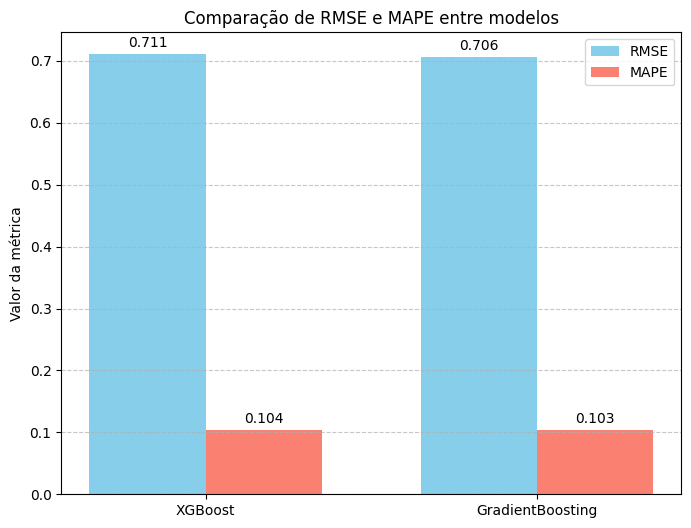

In [99]:
modelos = ["XGBoost", "GradientBoosting"]

rmse = [rmse_xgb, rmse_gbr]
mape = [mape_xgb, mape_gbr]

x = np.arange(len(modelos))  # posições dos modelos
largura = 0.35  # largura das barras

fig, ax = plt.subplots(figsize=(8, 6))

# Barras
barras_rmse = ax.bar(x - largura/2, rmse, largura, label="RMSE", color="skyblue")
barras_mape = ax.bar(x + largura/2, mape, largura, label="MAPE", color="salmon")

# Adiciona rótulos em cima das barras
ax.bar_label(barras_rmse, fmt="%.3f", padding=3)
ax.bar_label(barras_mape, fmt="%.3f", padding=3)

# Ajustes visuais
ax.set_ylabel("Valor da métrica")
ax.set_title("Comparação de RMSE e MAPE entre modelos")
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()